## Assignment 1 - Mnist with a simple (one hidden layer) Neural Net

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cpu") #Use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #If nvidea GPU is available use GPU
device

device(type='cuda', index=0)

Creating the nn.module for a neural network with two layers. 

In [19]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    self.D_out = D_out

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    Uses log_softmax
    """
    # flatten the tensor
    x = x.view(x.size(0), -1)
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return torch.nn.functional.log_softmax(y_pred, dim=1)

Setup vars that impact the time and effectivness of the training process.

In [20]:
batch_size_train = 64*10
batch_size_test = 1000
learning_rate = 1e-3
n_epoch = 50

Loading the mnist-dataset, pictures of handwritten numbers.

In [21]:
train_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
  transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
      (0.1307,), (0.3081,)),
  ]))


Precomputing the *torchvision.transforms* and loading the **complete** dataset on the GPU. This is not nessesary and in some cases a stupid idea, but in this case it causes a huge speedup. This is why we decided to keep it this way.

In [22]:
train_data = []
train_labels = []
for img, label in train_mnist:
    train_data.append(img)
    train_labels.append(label)

train_data = torch.stack(train_data)
train_labels = torch.tensor(train_labels)

train_data = train_data.to(device)
train_labels = train_labels.to(device)

train_loader = torch.utils.data.DataLoader(
  torch.utils.data.TensorDataset(train_data, train_labels),
  batch_size=batch_size_train, shuffle=True)

Loading the test-dataset. Here we don't precompute and don't transfer the data to the GPU because we will only use this data a few times. The train data will be used in multiple epochs so we get much more use out of the prepared data.

In [23]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])),
  batch_size=batch_size_test, shuffle=True)

Setting up the vars for the network. 

The hidden layer is 100 per assignment. 

The  output needs to be 10 for numbers 0-9.

And finally the input is 784=28*28 for the gray-value each pixel of a 28x28 image.

In [24]:
D_in, H, D_out = 784, 100, 10

In [25]:
model = TwoLayerNet(D_in, H, D_out)
model = model.to(device)
train_losses = []

Training the model using nn.functional.nll_loss as loss and optim.SGD as optimizer 

Time 
cpu(i5-9400F): 53.1s

gpu(4060 Ti): 39.1s

In [26]:
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.train()
for current_epoch in range(n_epoch):
  for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(batch_data)

    # Compute and print loss
    loss = loss_fn(y_pred, batch_labels)
    train_losses.append(loss.item())
    print(f"Epoch {current_epoch}, Batch {batch_idx}, Loss: {loss.item()}")



    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0, Batch 0, Loss: 2.3584201335906982
Epoch 0, Batch 1, Loss: 2.348037004470825
Epoch 0, Batch 2, Loss: 2.3575196266174316
Epoch 0, Batch 3, Loss: 2.3530869483947754
Epoch 0, Batch 4, Loss: 2.34489369392395
Epoch 0, Batch 5, Loss: 2.349109411239624
Epoch 0, Batch 6, Loss: 2.344327449798584
Epoch 0, Batch 7, Loss: 2.342656135559082
Epoch 0, Batch 8, Loss: 2.34576416015625
Epoch 0, Batch 9, Loss: 2.3485403060913086
Epoch 0, Batch 10, Loss: 2.3382277488708496
Epoch 0, Batch 11, Loss: 2.3534862995147705
Epoch 0, Batch 12, Loss: 2.3262929916381836
Epoch 0, Batch 13, Loss: 2.3463969230651855
Epoch 0, Batch 14, Loss: 2.331749439239502
Epoch 0, Batch 15, Loss: 2.3243298530578613
Epoch 0, Batch 16, Loss: 2.322272777557373
Epoch 0, Batch 17, Loss: 2.3208365440368652
Epoch 0, Batch 18, Loss: 2.321154832839966
Epoch 0, Batch 19, Loss: 2.332862138748169
Epoch 0, Batch 20, Loss: 2.3274924755096436
Epoch 0, Batch 21, Loss: 2.3237709999084473
Epoch 0, Batch 22, Loss: 2.316664218902588
Epoch 0, Ba

Text(0, 0.5, 'negative log likelihood loss')

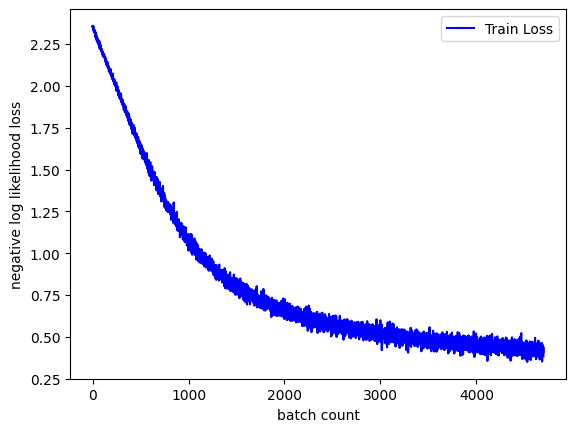

In [27]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('batch count')
plt.ylabel('negative log likelihood loss')

In [28]:
model.eval()
model.cpu()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    output = model(data)
    test_loss += torch.nn.functional.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.4037, Accuracy: 8921/10000 (89%)

